In [ ]:
# install kerastuner
!pip install -q -U keras-tuner

     |████████████████████████████████| 71kB 4.1MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

# change to working directory
%cd /content/drive/MyDrive/Colab-Notebooks/

Mounted at /content/drive/
/content/drive/MyDrive/Colab-Notebooks


In [ ]:
import os
from os import listdir
from os.path import join, isfile
import sys
from sys import platform
import cv2
import argparse
import datetime
from collections import Counter
import copy

import pandas as pd
from pandas import DataFrame
import numpy as np
from matplotlib import pyplot
import seaborn as sn
from mpl_toolkits.axes_grid1 import ImageGrid

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils import np_utils
from keras.optimizers import Adam
import kerastuner as kt
from kerastuner import HyperModel
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn import svm, metrics
from joblib import dump, load
import pickle

In [ ]:
categories = ["Boxing", "Facing", "HHold", "HShake", "XOXO"]
train_dataset = 'dataset_humiact5/train/'
test_dataset = 'dataset_humiact5/test/'

In [ ]:
def load_kp_feat_data_from_csv(dataset, dist_included=False):
    #
    # load keypoint feature data from csv files, split feature columns from label columns
    # Input:
    #   -dataset -path to the data set (train, or test)
    #   -dist_included -indicate whether or not distance dimension included
    # Ouput:
    #   -(X,y) -dataframe of feature data and label data 
    #
    
    df_ds = pd.DataFrame()
    for cat in categories:
        df = pd.read_csv(join(dataset, cat + "_keypoint_feature.csv"), index_col=0)
        labels = [cat for i in range(len(df.index))]
        df.insert(df.shape[1], "label", labels)
        df_ds = df_ds.append(df)

    # print(df_ds.shape)

    # separate features and labels
    if dist_included:
        X = df_ds.iloc[:, :-1]
    else:
        X = df_ds.iloc[:, :-2]
    
    y = df_ds.iloc[:, -1]
    
    # encode the labels
    encoder = LabelEncoder()
    encoder.fit(y)
    y = encoder.transform(y)

    # # save encoded classes if not exists
    # if not os.path.exists(join(dir_path, 'humiact5_saved_models/encoded-classes.joblib')):
    #     encoded_classes = list(encoder.classes_)
    #     dump(encoded_classes, 'humiact5_saved_models/encoded-classes.joblib')
    
    return (X,y)

In [ ]:
def show_confusion_matrix_and_save(y_pred, y_actual, title, save=False):
    #
    # show confusion matrix for mis-classification on validation set
    #
    confusion = confusion_matrix(y_actual, y_pred, normalize='pred');
    # print(confusion)

    df_cm = DataFrame(confusion, index=categories, columns=categories)

    fig, ax = pyplot.subplots(figsize=(7, 6))
    ax = sn.heatmap(df_cm, cmap='Oranges', annot=True, ax=ax)
    ax.set_ylabel('True')
    ax.set_xlabel('Predicted')
    ax.set_title(title)
    pyplot.show()

In [ ]:
# ======================================================================================== #
# ============================= HYPER-PARAMETER TUNING =================================== #
# ======================================================================================== #
    
class NNHyperModel(HyperModel):
    #
    # build a hyper model that inherits from HyperModel class
    #
    
    def __init__(self, input_dim, num_classes):
        self.input_dim = input_dim
        self.num_classes = num_classes
    
    def build(self, hp):
        model = keras.Sequential()

        # add one or more densely hidden layers (with or without a consecutive Dropout) before the output layer
        for i in range(hp.Int('layers',1, 3, default=1)):
            # ====== add 1st densely hidden layer with input_dim specified ======
            if i == 0:
                model.add(Dense(hp.Int('units_'+str(i), min_value=100, max_value=1000, step=100, default=200),
                                input_shape = (self.input_dim,),
                                activation= hp.Choice('activations_'+str(i), ['relu','sigmoid'], default='relu'))
                          )
                # model.add(Dropout(hp.Float('dropouts_'+str(i), min_value=0.0, max_value=0.3, step=0.05, default=0.0)))

            # ====== add the rest densely hidden layers if current 'layers' >= 2 ======
            else:
                model.add(Dense(hp.Int('units_' + str(i), min_value=100, max_value=1000, step=100, default=200),
                                activation= hp.Choice('activations_' + str(i), ['relu', 'sigmoid'], default='relu'))
                          )
                # model.add(Dropout(hp.Float('dropouts_' + str(i), min_value=0.0, max_value=0.3, step=0.05, default=0.0)))

        # ====== add the output layer with softmax ======
        model.add(Dense(self.num_classes, activation='softmax'))
        
        opt = Adam(learning_rate=hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, default=1e-3,
                                          sampling='LOG')
                   )
        
        model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
        
        return model

In [ ]:
def do_Hyperband_and_get_optimal_model():
    #
    # build a tuner, search for optimal hyper-parameters
    # Output:
    #   - the optimal model obtained after the tuning process 
    #
    
    # load the key-point feature data from csv files
    (X,y) = load_kp_feat_data_from_csv(train_dataset,dist_included=True)
    
    # get feature dimension
    num_feats = X.shape[1]
    num_cls = len(set(y))
    
    # initialize a NNHyperModel instance
    hypermodel = NNHyperModel(input_dim=num_feats,num_classes=num_cls)
    
    # init a Hyperband tuner
    tuner = kt.Hyperband(hypermodel, 
                         objective= 'val_accuracy',
                         max_epochs = 5,
                         factor= 3,
                         directory= 'hyperband-tuner',
                         project_name= 'humiact',
                         overwrite= True
                         )
    
    stop_early = keras.callbacks.EarlyStopping(monitor='val_loss', patience= 5)

    tuner.search_space_summary()
    
    tuner.search(X, y, epochs=3, validation_split=0.2, callbacks=[stop_early])

    tuner.results_summary()
    
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    
    # build the model with the optimal hyperparameters 
    model = tuner.hypermodel.build(best_hps)
    
    # return the optimal model
    return model

In [ ]:
def do_RandomSearch_and_get_optimal_model():
    #
    # build a tuner, search for optimal hyper-parameters
    # Output:
    #   - the optimal model obtained after the tuning process 
    #
    
    # load the key-point feature data from csv files
    (X,y) = load_kp_feat_data_from_csv(train_dataset,dist_included=True)
    
    # get feature dimension
    num_feats = X.shape[1]
    num_cls = len(set(y))
    
    # initialize a NNHyperModel instance
    hypermodel = NNHyperModel(input_dim=num_feats,num_classes=num_cls)
    
    # init a RandomSearch tuner
    tuner = kt.RandomSearch(hypermodel,
                            objective='val_accuracy',
                            max_trials=5,
                            executions_per_trial=3,
                            directory='randomsearch-tuner',
                            project_name= 'humiact',
                            overwrite=True)

    tuner.search_space_summary()

    tuner.search(x=X,
                 y=y,
                 epochs=3,
                 validation_split=0.2)

    tuner.results_summary()
    
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    
    # build the model with the optimal hyperparameters 
    model = tuner.hypermodel.build(best_hps)
    
    # return the optimal model
    return model

In [ ]:
# hyperparameter tuning
model = do_Hyperband_and_get_optimal_model()

# model = do_RandomSearch_and_get_optimal_model()

In [ ]:
# train a model with optimal configuration
# load the key-point feature data from csv files
(X,y) = load_kp_feat_data_from_csv(train_dataset,dist_included=True)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, shuffle=True)

history = model.fit(X_train, y_train,
                        validation_data=(X_val, y_val),
                        epochs=1000,
                        batch_size=16,
                        verbose=1
                        )
# show confusion matrix for mis-classification on validation set
y_pred_train = model.predict_classes(X_train)
y_pred = model.predict_classes(X_val)

show_confusion_matrix_and_save(y_pred_train, y_train, "NN network- Training set")
show_confusion_matrix_and_save(y_pred, y_val, "NN network- Validation set")

# print last epoch accuracy
# for training set and validation set
print("Best training accuracy: ")
print(max(history.history['accuracy']))
print("Best validation accuracy: ")
print(max(history.history['val_accuracy']))

# plot loss during training
pyplot.title('Training / Validation Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='val')
pyplot.legend()
pyplot.grid()
pyplot.show()

# plot accuracy during training
pyplot.title('Training / Validation Accuracy')
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='val')
pyplot.legend()
pyplot.grid()
pyplot.show()

In [ ]:
#region train and test modules
def baseline_model(input_dim, num_classes,
                   af='relu',lr=0.001,first_neurons=600):
    #
    # baseline model for classifying
    #
    
    # ===================================================================================================== #
    # ===== Tuning hyper-parameters by kerastuner =========
    # [optimal hyper-parameters obtained]:[model performance obtained using the optimal hyper-parameters]
    # ===================================================================================================== #
    #
    
    # STRUCTURE ATTEMPTS:
    # 1. NN model with 1 densly hidden layer and 1 hidden dropout
    # [units1=,lr=,af=]:[train-accuracy,val-accuracy]
    # - [units1=600, lr=0.001,af='relu']: [,]
    
    model = Sequential()
    # ============== Visible dropout case =============== #
    # model.add(Dropout(0.3, input_shape=(input_dim,)))
    # =================================================== #
    
    # === start 1st structure ===
    # 1st densely hidden layer #
    model.add(Dense(first_neurons, input_shape=(input_dim,), activation= af))

    # # 2nd densely hidden layer #
    # model.add(Dense(700, activation="sigmoid"))
    
    # === output layer with softmax ====
    model.add(Dense(num_classes, activation="softmax"))
    
    # === learning rate ===
    opt = Adam(learning_rate= lr)

    # compile model
    model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
    
    return model


In [ ]:
# build 1 hidden NN classifier
def build_and_save_NN_Classifier(epochs=250,batch_size=16, 
                                 af='relu',lr=0.001,first_neurons=600):
    # load dataset
    (X,y) = load_kp_feat_data_from_csv(train_dataset,dist_included=True)

    # apply scaler to each type of feature
    # trans = StandardScaler()
    # trans = MinMaxScaler()
    # X = trans.fit_transform(X)

    # split train and test set
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, shuffle=True)
    
    # get input shape and number of output classes
    num_feats = X_train.shape[1]
    num_cls = len(set(y))
    
    # create baseline model
    model = baseline_model(num_feats, num_cls, 
                           af='relu',lr=0.001,first_neurons=600)

    # fit the model
    print ("Model is fitting...")
    history = model.fit(X_train, y_train,
                        validation_data=(X_val, y_val),
                        epochs=epochs,
                        batch_size=batch_size,
                        verbose=0
                        )
    print ("Done!")

    # show confusion matrix for mis-classification on validation set
    y_pred_train = model.predict_classes(X_train)
    y_pred = model.predict_classes(X_val)

    show_confusion_matrix_and_save(y_pred_train, y_train, "NN network- Training set")
    show_confusion_matrix_and_save(y_pred, y_val, "NN network- Validation set")

    # print last epoch accuracy
    # for training set and validation set
    print("Best training accuracy: ")
    print(max(history.history['accuracy']))
    print("Best validation accuracy: ")
    print(max(history.history['val_accuracy']))

    # save the model
    model.save("humiact5_saved_models/NN-model(af={},lr={:.4f},neus={})".format(af,lr,first_neurons))

    # plot loss during training
    pyplot.title('Training / Validation Loss')
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='val')
    pyplot.legend()
    pyplot.grid()
    pyplot.show()

    # plot accuracy during training
    pyplot.title('Training / Validation Accuracy')
    pyplot.plot(history.history['accuracy'], label='train')
    pyplot.plot(history.history['val_accuracy'], label='val')
    pyplot.legend()
    pyplot.grid()
    pyplot.show()

Model is fitting...
Done!


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses

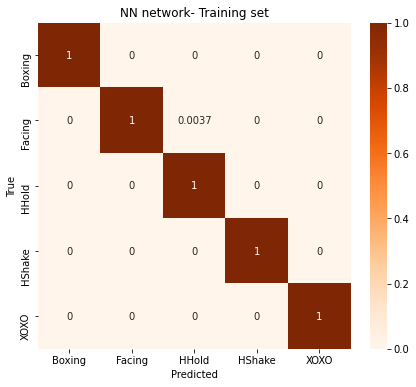

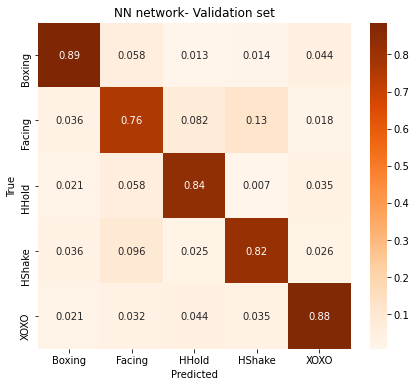

Best training accuracy: 
0.9979209899902344
Best validation accuracy: 
0.849507749080658
INFO:tensorflow:Assets written to: humiact5_saved_models/NN-model(af=relu,lr=0.0001,neus=600)/assets


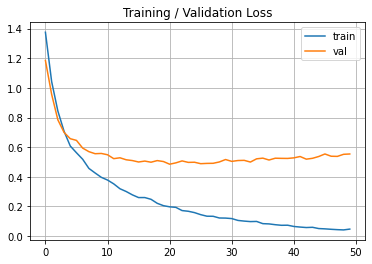

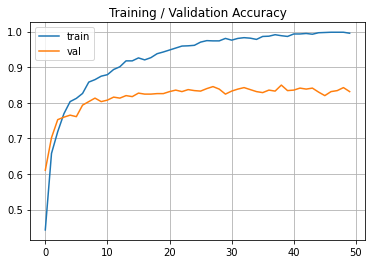

In [ ]:
# build the NN model with baseline structure
build_and_save_NN_Classifier(epochs=50,batch_size=32, 
                             af='relu',lr=0.0001,first_neurons=600)

In [ ]:
# load the trained model to predict test data
def evaluate_NN_Classifier_On_Test_Set(af='relu',lr=0.001,first_neurons=600):
    #
    # evaluate the accuracy of the model in test set
    #

    # load dataset    
    (X,y) = load_kp_feat_data_from_csv(test_dataset,dist_included=True)

    # # apply scaling to entire dataset
    # trans = StandardScaler()
    # trans = MinMaxScaler()
    # X = trans.fit_transform(X)

    # load NN classifier
    model = keras.models.load_model("humiact5_saved_models/NN-model(af={},lr={:.4f},neus={})".format(af,lr,first_neurons))

    # predict
    y_pred = model.predict_classes(X)

    # diagnose misclassified samples
    # 0:Boxing, 1:Facing, 2:HHold, 3:HShake, 4:XOXO
    # print_out_misclassified_samples(3, 1, y, y_pred)

    # show confusion matrix for mis-classification on validation set
    show_confusion_matrix_and_save(y_pred, y, "Misclassification on Test set, Neural Network")

    # Model Accuracy: how often is the classifier correct?
    print("Test accuracy:", metrics.accuracy_score(y, y_pred))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


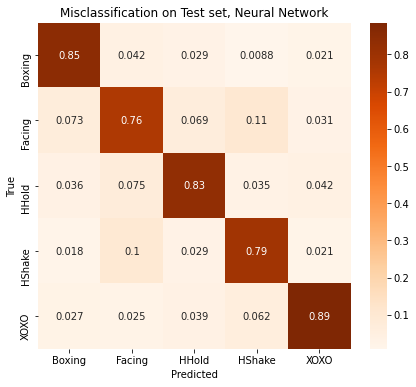

Test accuracy: 0.8188539741219963


In [ ]:
# evaluate the test set with a specific NN model configuration
evaluate_NN_Classifier_On_Test_Set(af='relu',lr=0.0001,first_neurons=600)

In [ ]:
def do_hyperparam_tuning_in_small_search_space(activation_fn= ('relu', 'sigmoid'),
                                               learning_rate= (-5, -2, 4),
                                               first_neurons= (100, 1000, 100),
                                               attempt= 5,
                                               epochs= 200
                                               ):
    #
    # This function is to conduct experiments of hyper-parameter tuning for small, specific search space
    # Three types of hyper-parameter are involved: activation function, learning rate, and the number of
    # neurons in the first densely hidden layer (for only the NN with 1 densely hidden layer).
    # For each specific hyper-parameter configuration, to reduce variance in performance, we will repeatedly
    # train each model number of times ('attempt') and consider its average result.
    # Input:
    #   -activation_fn -activation function involved in search space
    #   -learning_rate -learning rate range obeys log space (e.g. from 1e-5 to 1e-2 for 4 samples)
    #   -first_neurons -the range of the number of neurons in the first densely hidden layer
    #   Format: (start, stop, step)
    #   -attempt -number of of times to train each model in order to reduce variance in the obtained result
    #   The average values will be taken into consideration
    #   -epochs -number of epochs each neural network model will be trained
    #

    # load data features for training
    (X,y) = load_kp_feat_data_from_csv(train_dataset,dist_included=True)
    # get input shape and number of output classes
    num_feats = X.shape[1]
    num_cls = len(set(y))

    # parse parameters
    # activation function
    n_af = len(activation_fn)
    # learning rate
    learning_rate = np.logspace(learning_rate[0],learning_rate[1],learning_rate[2])
    n_lr = len(learning_rate)
    # first neurons
    first_neurons = list(range(first_neurons[0],first_neurons[1]+1,first_neurons[2]))
    n_neus = len(first_neurons)

    # create a ndarray to record all experiments data
    # metrics involved for measurement
    metrics = ('loss', 'accuracy', 'val_loss', 'val_accuracy')
    n_mts = len(metrics)

    # detailed data array
    detailed_tuning_data = np.array(np.zeros(shape=(n_af,n_lr,n_neus,attempt,epochs,n_mts)))

    # summary data array
    summary_tuning_data = np.array(np.zeros(shape=(n_af,n_lr,n_neus,n_mts)))

    # search space
    for af in range(n_af):
        for lr in range(n_lr):
            for neur in range(n_neus):
                # for each configuration, calculate average of the best acc/loss of train/val set
                avg_best_values = np.zeros(shape=(1,n_mts)) # loss,acc,val_loss,val_acc

                # number of attempts
                for att in range(attempt):

                    # re-split train/val set each time
                    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, shuffle=True)

                    # init a neural network
                    # create a NN model with current hyper-parameters
                    model = baseline_model(num_feats, num_cls,
                                           activation_fn[af],
                                           learning_rate[lr],
                                           first_neurons[neur]
                                           )
                    
                    # fit the model
                    print ("\n=============================================================================")
                    print ("NN model (af={},lr={},neurons={},attempt={}) is fitting...".format(activation_fn[af],
                                                                    learning_rate[lr],
                                                                    first_neurons[neur],
                                                                    att+1))
                    history = model.fit(X_train, y_train,
                                        validation_data=(X_val, y_val),
                                        epochs=epochs,
                                        batch_size=16,
                                        verbose=1
                                        )

                    # save the history data
                    # loss
                    detailed_tuning_data[af,lr,neur,att,:,0] = history.history['loss']
                    # accuracy
                    detailed_tuning_data[af,lr,neur,att,:,1] = history.history['accuracy']
                    # val_loss
                    detailed_tuning_data[af,lr,neur,att,:,2] = history.history['val_loss']
                    # val_accuracy
                    detailed_tuning_data[af,lr,neur,att,:,3] = history.history['val_accuracy']

                    # get the index where validation accuracy is highest
                    best_idx = history.history['val_accuracy'].index(max(history.history['val_accuracy']))

                    # accumulate all values of the 4 metrics at this index
                    avg_best_values = np.add(avg_best_values, [history.history['loss'][best_idx],
                                                               history.history['accuracy'][best_idx],
                                                               history.history['val_loss'][best_idx],
                                                               history.history['val_accuracy'][best_idx]])
                # average the values
                avg_best_values /= attempt

                # add average data to summary tuning array
                summary_tuning_data[af,lr,neur,:] = avg_best_values

    # save all ndarray data to files
    # save detailed tuning data
    np.save("NN_hyperparameter-tuning/humiact5_tuning_history_data/detailed_tuning_data.npy",
            detailed_tuning_data)
    # save summary tuning data
    np.save("NN_hyperparameter-tuning/humiact5_tuning_history_data/summary_tuning_data.npy",
            summary_tuning_data)

    pass


In [ ]:
# from IPython.core.debugger import set_trace

def plot_hyperparam_configuration_summary_performance(activation_fn,
                                                      learning_rate,
                                                      first_neurons,
                                                      metric='val_accuarcy'):
    #
    # build performance chart based on summary tuning data
    # Type: A line chart with Y-axis is accuracy or loss, Y-axis is number of first-neurons;
    #       Each line in the chart is corresponding with a specific combination of
    #       activation function and learning rate values
    # Input:
    #   -metric -a metric on which the performance is measured (loss,accuracy,val_loss,val_accuracy)
    # Output:
    #   -void() -show a chart which is appropriate with input params
    #

    # load the summary data from file
    summary_tuning_data = np.load("NN_hyperparameter-tuning/humiact5_tuning_history_data/summary_tuning_data.npy")

    # parse parameters
    # activation function
    n_af = len(activation_fn)
    # learning rate
    learning_rate = np.logspace(learning_rate[0], learning_rate[1], learning_rate[2])
    n_lr = len(learning_rate)
    # first neurons
    first_neurons = list(range(first_neurons[0], first_neurons[1] + 1, first_neurons[2]))
    n_neus = len(first_neurons)

    # check validity
    assert n_af == summary_tuning_data.shape[0]
    assert n_lr == summary_tuning_data.shape[1]
    assert n_neus == summary_tuning_data.shape[2]

    metric_idx = -1
    if metric == 'loss':
        metric_idx = 0
    elif metric == 'accuracy':
        metric_idx = 1
    elif metric == 'val_loss':
        metric_idx = 2
    elif metric == 'val_accuracy':
        metric_idx = 3

    assert metric_idx >= 0

    # plot the chart
    pyplot.figure(figsize=(10,7))
    pyplot.title("Hyper-parameter tuning- {} (humiact5)".format(metric), fontsize=16)

    for af in range(n_af):
        for lr in range(n_lr):
            # build legend of each line [activation-func_learning-rate]
            legend = "{}, lr={:.4f}".format(activation_fn[af],learning_rate[lr])

            pyplot.plot(first_neurons, summary_tuning_data[af,lr,:,metric_idx], label= legend)

    pyplot.xticks(first_neurons)
    pyplot.xlabel("First-layer Neurons", fontsize=12)
    pyplot.legend(loc='lower center', bbox_to_anchor=(0.5, -0.25), ncol=n_lr)
    pyplot.subplots_adjust(bottom=0.2)
    pyplot.grid()
    pyplot.show()

    pass

In [ ]:
# ============ do tuning in a small search space ==============
# should be fixed the search space for plotting chart properly
activation_fn = ('relu','sigmoid')
learning_rate = (-4, -3, 3)
first_neurons = (100, 1000, 100)

attempt = 3
epochs = 250


In [ ]:
do_hyperparam_tuning_in_small_search_space(activation_fn= activation_fn,
                                           learning_rate= learning_rate,
                                           first_neurons= first_neurons,
                                           attempt= attempt,
                                           epochs= epochs
                                           )

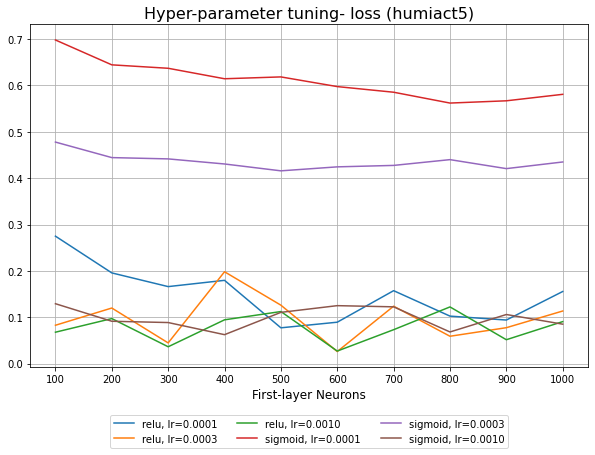

In [ ]:
# plot statistical chart
plot_hyperparam_configuration_summary_performance(activation_fn,
                                                  learning_rate,
                                                  first_neurons,
                                                  metric='loss')

In [ ]:
# this function is to plot learning curve of a specific trained model
# based on the detailed_tuning_data 
# parameter of the data:
# af=('relu','sigmoid'), lr=(-4,-3,3), n_neus=(100,1000,100), attempt=3
def plot_learning_curve(activation_fn='relu',learning_rate=0.001,first_neurons=600,attempt=0):

    dim1,dim2,dim3,dim4 = -1,-1,-1,attempt

    if activation_fn=='relu':
      dim1 = 0
    elif activation_fn=='sigmoid':
      dim1 = 1
    if learning_rate==0.0001:
      dim2 = 0
    elif learning_rate==0.0003:
      dim2 = 1
    elif learning_rate==0.001:
      dim2 = 2
    
    dim3 = (first_neurons-100)//100

    assert dim1 >= 0 and dim2 >=0 and dim3 >=0 and dim4 >=0

    # load detailed tuning data
    detailed_data = np.load("NN_hyperparameter-tuning/humiact5_tuning_history_data/detailed_tuning_data.npy")

    # access appropriate data
    history = detailed_data[dim1,dim2,dim3,dim4]

    # loss, acc, val_loss, val_acc
    loss, accuracy, val_loss, val_accuracy = history[:,0],history[:,1],history[:,2],history[:,3]
    
    # plot loss of the training
    pyplot.title('Training / Validation Loss')
    pyplot.plot(loss, label='train')
    pyplot.plot(val_loss, label='val')
    pyplot.legend()
    pyplot.grid()
    pyplot.show()

    # plot accuracy of the training
    pyplot.title('Training / Validation Accuracy')
    pyplot.plot(accuracy, label='train')
    pyplot.plot(val_accuracy, label='val')
    pyplot.legend()
    pyplot.grid()
    pyplot.show()

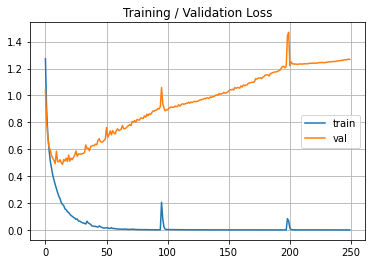

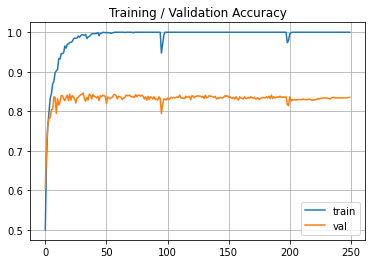

In [ ]:
plot_learning_curve(activation_fn='relu',learning_rate=0.001,first_neurons=600,attempt=2)